In [89]:
include("../code/ldgm.jl")
include("../code/ldpc_graph.jl")

_check_consistency_polynomials_edges (generic function with 1 method)

## BP

In [104]:
rho = zeros(7); rho[7] = 1
lambda = [0, 0.2742857142857143, 0.2571428571428571, 0.08, 0,0,0,0, 0.3885714285714287]
# lambda = [0, 0.276598, 0.25537, 0.076598, 0, 0, 0, 0, 0.39233]
m = 50
nedges = 7m
[nedges*lambda[i]/i for i in eachindex(lambda)]
# n = Int(sum(nedges*lambda[i]/i for i in eachindex(lambda)))
# ldpc_graphGF2(n,m,nedges,rho,lambda)

9-element Vector{Float64}:
  0.0
 48.0
 29.999999999999996
  7.0
  0.0
  0.0
  0.0
  0.0
 15.111111111111114

In [102]:
1-sum(lambda[1:end-1])

0.3885714285714287

In [22]:
sum(rho)

0.9971428571428571

In [18]:
15*9/350

0.38571428571428573

In [136]:
k = 2300
nedges = 2*k
n = Int(round(nedges/2.3, digits=10))
# m = round(Int, n*(1-R))
# nedges, Λ, K = generate_polyn(n,m,degree_type=:nodes)
# b = 100
# G = ldpc_matrix(n, m, nedges, Λ, K)
# # remove b factors
# G = G[:,1:end-b];

In [138]:
k = 2300
nedges = 2*k
n = Int(round(nedges/2.3, digits=10))
R = k/n

1.15

In [ ]:
Λ = [0,1,0]
K = [0, 0.7, 0.3]
n = 7200*10

In [130]:
k = size(G,2)
R = k/n
ξ = 0.02
@show β = (1-ξ)/(1+ξ)
@show H = atanh(β)
s = rand((-1,1), n)   # source
efield = [(exp(ss*H),exp(-ss*H)) for ss in s]
bp = LDGM(G, efield);

β = (1 - ξ) / (1 + ξ) = 0.9607843137254901
H = atanh(β) = 1.9560115027140719


In [131]:
ε, niters = iteration!(bp, maxiter=5*10^4, damp=0.9)

(0.22941040564555126, 50000)

In [132]:
ovl,dist = performance(bp, s)

(0.8488055555555556, 0.07559722222222222)

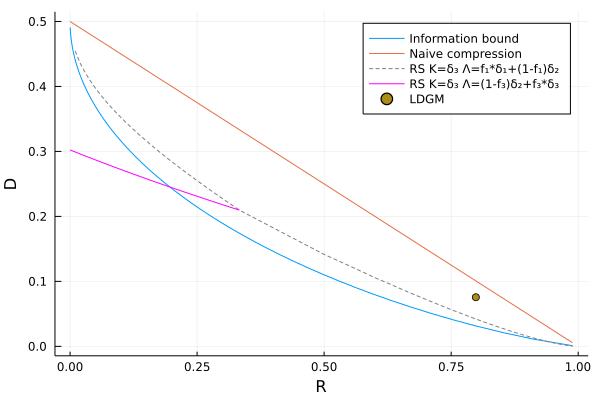

In [133]:
pl = plot_rdb()
scatter!([R], [dist], label="LDGM")

## BP, varying rate
Factors of degree 2, variables of degree 1 and 2

In [154]:
rr = 0.1:0.1:0.9
RR = zero(rr)
DD = zero(rr)
DD_sd = zero(rr)
navg = 5
n = 7200
H = 15
for (i,r) in enumerate(rr)
    println("$i of ", length(rr), " finished")
    m = round(Int, n*(1-r))
    nedges, Λ, K = generate_polyn(n,m,degree_type=:nodes)
    D = zeros(navg)
    for j in 1:navg
        G = ldpc_matrix(n, m, nedges, Λ, K)
        G = G[:,1:end-1];
        RR[i] = size(G,2)/n
        s = rand((-1,1), n)   # source
        efield = [(exp(ss*H),exp(-ss*H)) for ss in s]
        bp = LDGM(G, efield);
        ε, niters = iteration!(bp, maxiter=10^4, damp=0.5)
        ovl, D[j] = performance(bp, s)
    end
    DD[i] = mean(D)
    DD_sd[i] = std(D)/sqrt(navg)
end

1 of 9 finished


LoadError: InterruptException:

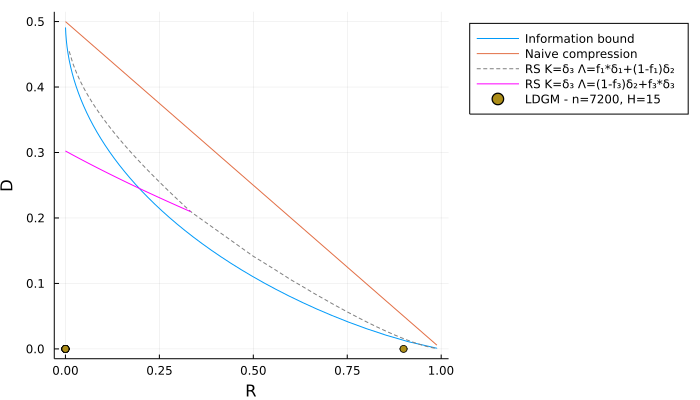

In [155]:
plot_rdb()
scatter!(RR,DD, label="LDGM - n=$n, H=$H", yerr=DD_sd, legend=:outertopright, size=(700,400))

## Max-Sum

Factors of degree 2, variables of degree 1 and 2

In [51]:
n = 7200
@show n
r = 0.7
m = round(Int, n*(1-r))
nedges, Λ, K = generate_polyn(n,m,degree_type=:nodes)
b = 100
G = ldpc_matrix(n, m, nedges, Λ, K)
# remove b factors
G = G[:,1:end-b];

n = 7200


In [52]:
k = size(G,2)
R = k/n
H = 1
s = rand((-1,1), n)   # source
efield = [float.((ss*H,-ss*H)) for ss in s]
ms = LDGM(G, efield);

In [53]:
ε, niters = iteration!(ms, maxiter=10^4, damp=0.5, update_v! = update_var_ms!, update_f! = update_factor_ms!)

(4.092309793800276, 10000)

In [54]:
ovl,dist = performance(ms, s)

(0.43000000000000005, 0.285)

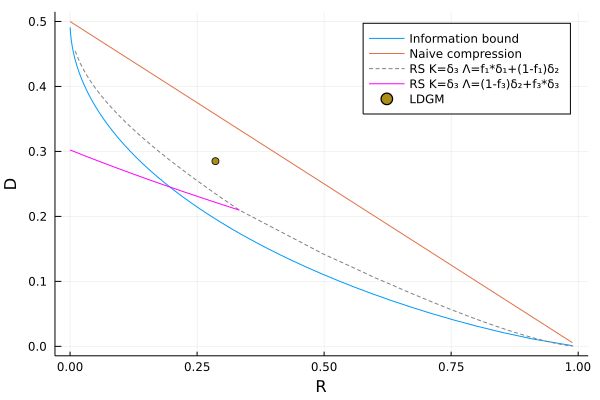

In [55]:
pl = plot_rdb()
scatter!([R], [dist], label="LDGM")